# Analysis of Temperature Data
A simple Raspberry Pi and DHT22 Temperature and Humidity sensor

## Import Required libraries

In [65]:
from pprint import pformat as pf, pprint as pp
import json
import logging
import os

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

import requests
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa import stattools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import arma_generate_sample
np.random.seed(3)


import matplotlib.pyplot as plt
import itermplot
%matplotlib inline

print(os.environ.get('MPLBACKEND', ''))
print(statsmodels.__version__)
print(np.__version__)
print(pd.__version__)

module://itermplot
0.10.1
1.17.2
0.25.1


# Fetch Data

In [66]:
url = 'http://192.168.0.156:8000/metrics?from=300'
response = requests.get(url)
status_code = response.status_code
#status_code = 404

In [67]:

if status_code == 200:
    print("web")
    data = json.loads(response.content.decode('utf-8'))
else:
    print("local")
    with open('sample.json', 'r') as f:
        data = json.load(f)


web


# Tidy Data

In [68]:
df = pd.DataFrame(data)
df

,metric,ts,value
0,humidity,1.574849e+09,52.799999
1,temperature,1.574849e+09,23.512121
2,humidity,1.574849e+09,52.776470
3,temperature,1.574849e+09,23.560785
4,humidity,1.574848e+09,52.753061
...,...,...,...
36251,temperature,1.569138e+09,24.498077
36252,humidity,1.569138e+09,78.126413
36253,temperature,1.569138e+09,24.500000
36254,humidity,1.569137e+09,78.282355


In [69]:
df['ts'] = pd.to_datetime(df['ts'], unit='s')
df

,metric,ts,value
0,humidity,2019-11-27 09:59:13.341517210,52.799999
1,temperature,2019-11-27 09:59:13.341517210,23.512121
2,humidity,2019-11-27 09:55:03.209787607,52.776470
3,temperature,2019-11-27 09:55:03.209787607,23.560785
4,humidity,2019-11-27 09:50:05.322507858,52.753061
...,...,...,...
36251,temperature,2019-09-22 07:40:04.500892878,24.498077
36252,humidity,2019-09-22 07:35:00.818114996,78.126413
36253,temperature,2019-09-22 07:35:00.818114996,24.500000
36254,humidity,2019-09-22 07:30:08.879276752,78.282355


In [70]:
df = df.set_index('ts')
df

,metric,value
ts,,
2019-11-27 09:59:13.341517210,humidity,52.799999
2019-11-27 09:59:13.341517210,temperature,23.512121
2019-11-27 09:55:03.209787607,humidity,52.776470
2019-11-27 09:55:03.209787607,temperature,23.560785
2019-11-27 09:50:05.322507858,humidity,52.753061
...,...,...
2019-09-22 07:40:04.500892878,temperature,24.498077
2019-09-22 07:35:00.818114996,humidity,78.126413
2019-09-22 07:35:00.818114996,temperature,24.500000


In [71]:
df = df.dropna()
df_temp = df[df['metric'] == 'temperature'][['value']].resample('H').mean()
df_temp.index

DatetimeIndex(['2019-09-22 07:00:00', '2019-09-22 08:00:00',
               '2019-09-22 09:00:00', '2019-09-22 10:00:00',
               '2019-09-22 11:00:00', '2019-09-22 12:00:00',
               '2019-09-22 13:00:00', '2019-09-22 14:00:00',
               '2019-09-22 15:00:00', '2019-09-22 16:00:00',
               ...
               '2019-11-27 00:00:00', '2019-11-27 01:00:00',
               '2019-11-27 02:00:00', '2019-11-27 03:00:00',
               '2019-11-27 04:00:00', '2019-11-27 05:00:00',
               '2019-11-27 06:00:00', '2019-11-27 07:00:00',
               '2019-11-27 08:00:00', '2019-11-27 09:00:00'],
              dtype='datetime64[ns]', name='ts', length=1587, freq='H')

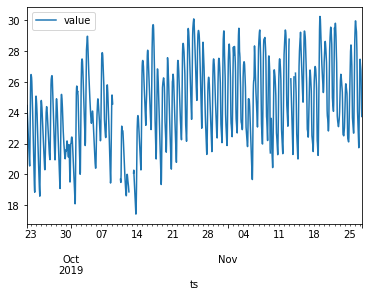

In [72]:
df_temp.plot()

# Differencing

In [73]:
df_diff = df_temp.diff().dropna()

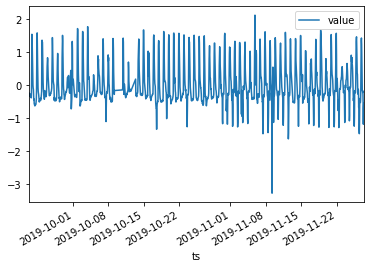

In [74]:
df_diff.plot()

# Stationarity Tests
## Augmented Dickey-Fuller Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller

> Null Hypothesis (H0): Time Series is NOT stationary. 

**adf**: `float`

Test statistic

**pvalue**: `float`

MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)

**usedlag**: `int`

Number of lags used

**nobs**: `int`

Number of observations used for the ADF regression and calculation of the critical values

**critical values**: `dict`

Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010)

**icbest**: `float`
The maximized information criterion if autolag is not None.

In [75]:
print("TEMPERATURE")
results = stattools.adfuller(df_temp['value'].dropna())

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

TEMPERATURE
p-value: 0.0001997505070132987
Reject H0. Reject non-stationary. It could be stationary.


In [76]:
print("DIFFERENCED")
results = stattools.adfuller(df_diff['value'].dropna())

adf, pvalue, usedlag, no_obs, critical_values, ic_best = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject non-stationary. It could be stationary.")
else:
    print("Could not reject H0. It is not likely stationary.")

DIFFERENCED
p-value: 2.9920068964733717e-12
Reject H0. Reject non-stationary. It could be stationary.


## KPSS Test

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html#statsmodels.tsa.stattools.kpss

> Null Hypothesis (H0): Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null hypothesis that x is level or trend stationary.

**kpss_stat**: `float`

The KPSS test statistic

**p_value**: `float`

The p-value of the test. The p-value is interpolated from Table 1 in Kwiatkowski et al. (1992), and a boundary point is returned if the test statistic is outside the table of critical values, that is, if the p-value is outside the interval (0.01, 0.1).

**lags**: `int`

The truncation lag parameter

**crit**: `dict`

The critical values at 10%, 5%, 2.5% and 1%. Based on Kwiatkowski et al. (1992).


In [77]:
print("TEMPERATURE")
results = stattools.kpss(df_temp['value'].dropna(), regression='ct', lags='auto')

kpss_stat, pvalue, lags, critical_values = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject stationary. It could be non-stationary.")
else:
    print("Could not reject H0. It is likely stationary.")

TEMPERATURE
p-value: 0.031052508942528728
Reject H0. Reject stationary. It could be non-stationary.


In [78]:
print("DIFFERENCED")
results = stattools.kpss(df_diff['value'].dropna(), regression='ct', lags='auto')

kpss_stat, pvalue, lags, critical_values = results

print(f"p-value: {pvalue}")
if pvalue < 0.05:
    print("Reject H0. Reject stationary. It could be non-stationary.")
else:
    print("Could not reject H0. It is likely stationary.")

DIFFERENCED
p-value: 0.1
Could not reject H0. It is likely stationary.


/Users/jpeak/projects/temperature-timeseries/v/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


# Auto Correlation Plots

In [79]:
df_acf = pd.DataFrame(stattools.acf(df_temp.dropna(), fft=True))

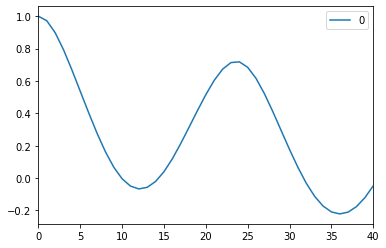

In [80]:
df_acf.plot()

In [81]:
df_pacf = pd.DataFrame(stattools.pacf(df_temp.dropna(), method='ols-inefficient'))

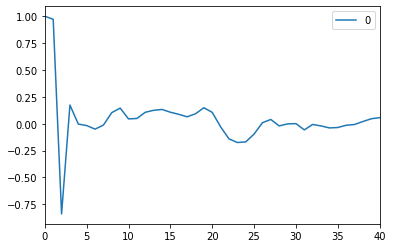

In [82]:
df_pacf.plot()

In [83]:
df_pacf[:6]

,0
0,1.000000
1,0.971511
2,-0.839758
3,0.173531
4,-0.003429
5,-0.017386


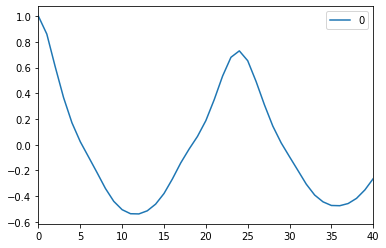

In [84]:
df_diff_acf = pd.DataFrame(stattools.acf(df_diff.dropna()))
df_diff_acf.plot()

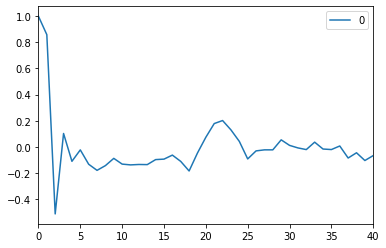

In [85]:
df_diff_pacf = pd.DataFrame(stattools.pacf(df_diff.dropna(), method='ols-inefficient'))
df_diff_pacf.plot()

## ACF

The Auto Correlation Function, has strong correlation at lags 12, 24, 36 but overall decays slowly.

## PACF

The Partial Auto Correlation function drops off rapidly after 2 lags which suggests a strong Auto Regressive relationship. 

Lets look at fitting an ARIMA model next.

# ARIMA

In [86]:
df_temp.to_csv("data.csv")

In [87]:
df_temp.index

DatetimeIndex(['2019-09-22 07:00:00', '2019-09-22 08:00:00',
               '2019-09-22 09:00:00', '2019-09-22 10:00:00',
               '2019-09-22 11:00:00', '2019-09-22 12:00:00',
               '2019-09-22 13:00:00', '2019-09-22 14:00:00',
               '2019-09-22 15:00:00', '2019-09-22 16:00:00',
               ...
               '2019-11-27 00:00:00', '2019-11-27 01:00:00',
               '2019-11-27 02:00:00', '2019-11-27 03:00:00',
               '2019-11-27 04:00:00', '2019-11-27 05:00:00',
               '2019-11-27 06:00:00', '2019-11-27 07:00:00',
               '2019-11-27 08:00:00', '2019-11-27 09:00:00'],
              dtype='datetime64[ns]', name='ts', length=1587, freq='H')

In [139]:
model = SARIMAX(df_temp['value'].dropna(), order=(6,1,1))
results = model.fit()

/Users/jpeak/projects/temperature-timeseries/v/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [140]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  value   No. Observations:                 1516
Model:               SARIMAX(6, 1, 1)   Log Likelihood                -456.499
Date:                Wed, 27 Nov 2019   AIC                            928.997
Time:                        21:28:58   BIC                            971.583
Sample:                             0   HQIC                           944.854
                               - 1516                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8256      0.020     92.263      0.000       1.787       1.864
ar.L2         -1.0506      0.026    -40.515      0.000      -1.101      -1.000
ar.L3          0.1473      0.031      4.823      0.000       0.087       0.207
ar.L4         -0.0526      0.042     -1.266      0.206      -0.134       0.029
ar.L5          0.1775      0.041      4.353      0.000       0.098       0.257
ar.L6         -0.1521      0.023     -6.622      0.000      -0.197      -0.107
ma.L1         -0.9183      0.014    -65.151      0.000      -0.946      -0.891
sigma2         0.1068      0.001     86.362      0.000       0.104       0.109
===================================================================================
Ljung-Box (Q):                      234.42   Jarque-Bera (JB):            199257.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.28
Prob(H) (two-sided):                  0.27   Kurtosis:                        59.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/jpeak/projects/temperature-timeseries/v/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


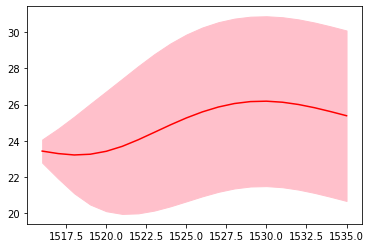

In [144]:
#forecast = results.get_prediction(start=-25, dynamic=True)
forecast = results.get_forecast(steps=20)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

plt.figure()

plt.plot(
    mean_forecast.index, 
    mean_forecast.values, 
    color='red', 
    label='forecast'
)
plt.fill_between(
    confidence_intervals.index, 
    confidence_intervals['lower value'], 
    confidence_intervals['upper value'], 
    color='pink'
)